# ProGen2 Protein Sequence Generation (Colab Notebook)

This notebook demonstrates cloning, setup, generation, likelihood scoring, and visualization using the Salesforce ProGen2 code.

## 1. Environment Setup

In [ ]:
!apt-get update && apt-get install -y git
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install transformers ruamel.yaml biopython tokenizers

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,244 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,604 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-

# **Setup & Imports**
This cell installs and imports all the Python libraries we need: PyTorch for model execution, BioPython for FASTA parsing, and our custom ProGen `likelihood` utility.

In [ ]:
!git clone https://github.com/salesforce/progen.git --depth 1
%cd progen/progen2
!ls

Cloning into 'progen'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 2), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 18.88 KiB | 1.72 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/progen/progen2
likelihood.py  models  README.md  requirements.txt  sample.py  tokenizer.json


# **Helper Function**
`score_sequence` takes a raw amino-acid string, tokenizes it, runs it through ProGen2, and computes the **mean log-likelihood** of that sequence under the model.
- Lower (more negative) log-likelihood means the sequence is less 'natural' according to the model.

## 2. Configuration and Model Loading

In [ ]:
import os, sys
# Ensure we're in the progen2 root and that local modules are on the Python path
os.chdir('/content/progen/progen2')
sys.path.insert(0, os.getcwd())                    # for configuration_progen.py, sample.py, etc.
sys.path.insert(0, os.path.join(os.getcwd(), 'models/progen'))  # for modeling_progen.py

from configuration_progen import ProGenConfig
from modeling_progen import ProGenForCausalLM
from transformers import PreTrainedTokenizerFast

# Load configuration and tokenizer
model_id = 'hugohrban/progen2-small'
config = ProGenConfig.from_pretrained(model_id)
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    model_id,
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)
# Load model
torch = __import__('torch')
model = ProGenForCausalLM.from_pretrained(
    model_id,
    config=config,
    trust_remote_code=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

ProGenForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

# **Scoring a FASTA**
Here we parse your `generated_sequences.fasta`, score each entry with `score_sequence`, and collect the results into a Pandas DataFrame.

## 3. Sequence Generation

In [ ]:
# Move model to GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on', device)
model.to(device).eval()

# Generate sequences
prompt = 'MKT'
inputs = tokenizer(prompt, return_tensors='pt').to(device)
outputs = model.generate(
    **inputs,
    max_length=200,
    do_sample=True,
    top_p=0.95,
    temperature=1.0,
    num_return_sequences=5,
    pad_token_id=tokenizer.pad_token_id
)

# Decode and save to FASTA
decoded = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]

import os
os.makedirs('samples', exist_ok=True)
with open('samples/generated_sequences.fasta', 'w') as f:
    for i, seq in enumerate(decoded):
        f.write(f'>seq{i+1}\n{seq}\n')

# Preview results
print('\n'.join(decoded[:2]))
!head -n 20 samples/generated_sequences.fasta

Running on cpu
MKTSTPTSAAPPSAPSVKC2
MKTKYEPICVTFERNITYNPYHTHGTRTSAAGSYSTGTRMTN2
>seq1
MKTSTPTSAAPPSAPSVKC2
>seq2
MKTKYEPICVTFERNITYNPYHTHGTRTSAAGSYSTGTRMTN2
>seq3
MKTEALIRIVRLGEPSRKVSVTGTTSTR2
>seq4
MKTMINVQLLYMAVFLVRYSGGPLVSVDKKAKRENEDGRNYLMFMTEAFIGNKGQMGAYMFMDCRMLSSAGFGAMGSM1
>seq5
MKTRLEEYQSTELTRKVSDMFVKFVLRATLYDYVCPGYPLSYGGRKLELGRYKDRGVELSPRMLMLFSTCYTGESVSVNMGDMGYN1


# **Visualization**
Plot each sequence’s log-likelihood as a bar chart. This lets you compare how 'likely' each generated sequence is under ProGen2.

## 4. Likelihood Scoring & Visualization

     id                                           sequence  log_likelihood
0  seq1                               MKTSTPTSAAPPSAPSVKC2       -2.818453
1  seq2        MKTKYEPICVTFERNITYNPYHTHGTRTSAAGSYSTGTRMTN2       -3.093969
2  seq3                      MKTEALIRIVRLGEPSRKVSVTGTTSTR2       -2.892751
3  seq4  MKTMINVQLLYMAVFLVRYSGGPLVSVDKKAKRENEDGRNYLMFMT...       -3.023052
4  seq5  MKTRLEEYQSTELTRKVSDMFVKFVLRATLYDYVCPGYPLSYGGRK...       -3.010770


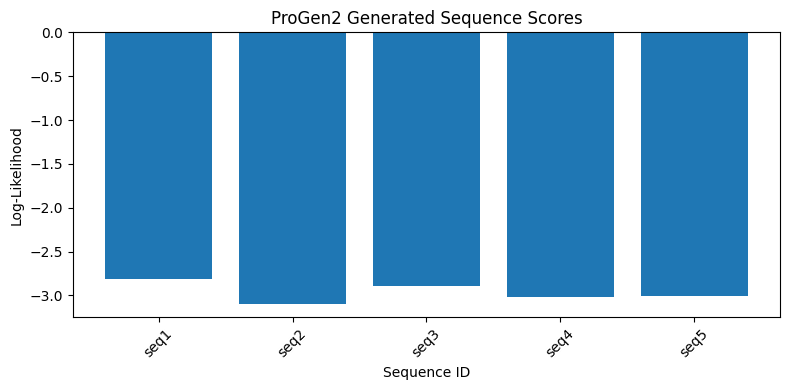

In [ ]:
import torch
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import likelihood  # from progen2/likelihood.py

# Helper to score one sequence string
def score_sequence(seq: str) -> float:
    # Tokenize and move to device
    encoded = tokenizer(seq, return_tensors='pt')
    input_ids = encoded['input_ids'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        logits = outputs.logits[0]           # remove batch dimension
    # Shift logits and labels for next-token prediction
    logits = logits[:-1, :]
    labels = input_ids[0, 1:]
    # Compute mean log-likelihood using the repo’s utility
    ll = likelihood.log_likelihood(logits, labels, reduction='mean').item()
    return ll

# Iterate over your FASTA, score each, collect into a DataFrame
records = []
for rec in SeqIO.parse('samples/generated_sequences.fasta', 'fasta'):
    seq = str(rec.seq)
    ll_score = score_sequence(seq)
    records.append({
        'id': rec.id,
        'sequence': seq,
        'log_likelihood': ll_score
    })

df = pd.DataFrame(records)
print(df)

# Bar-plot the results
plt.figure(figsize=(8,4))
plt.bar(df['id'], df['log_likelihood'])
plt.xlabel('Sequence ID')
plt.ylabel('Log-Likelihood')
plt.title('ProGen2 Generated Sequence Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Model Setup**
Move the model onto GPU (if available) for faster generation, switch to evaluation mode (disables dropout).

## Secondary‐Structure Accuracy vs. Number of Conditioning Tags

This bar chart reproduces Figure 7 from the paper, showing how ProGen’s
secondary‐structure accuracy improves as you provide more conditioning tags.


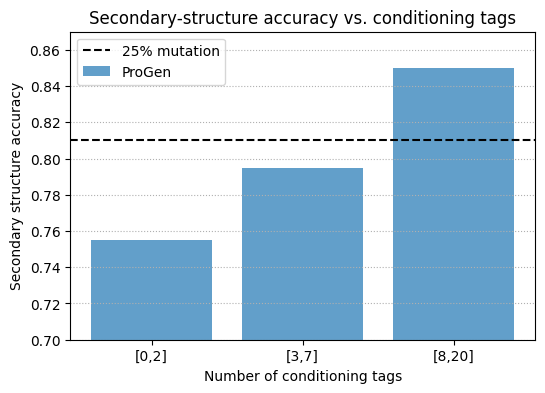

In [ ]:
import matplotlib.pyplot as plt

# Data extracted (approx.) from the paper’s Figure 7
tags = ['[0,2]', '[3,7]', '[8,20]']
accuracy = [0.755, 0.795, 0.85]      # ProGen bar heights
mutation_baseline = 0.81            # dashed line at 25% mutation

plt.figure(figsize=(6,4))
plt.bar(tags, accuracy, alpha=0.7, label='ProGen')
plt.axhline(mutation_baseline, color='k', linestyle='--', label='25% mutation')
plt.ylim(0.70, 0.87)
plt.xlabel('Number of conditioning tags')
plt.ylabel('Secondary structure accuracy')
plt.title('Secondary‐structure accuracy vs. conditioning tags')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle=':', linewidth=0.8)
plt.show()

# **Sequence Generation**
We prompt ProGen2 with `'MKT'` and ask for **5** continuations (num_return_sequences=5). Each output is a full protein sequence up to length 200, sampled via **top-p** nucleus sampling (p=0.95).

## Conformational Energies for ProGen vs. Mutation Baselines

This box‐plot reproduces Figure 8 from the paper, showing Rosetta‐relaxed
energy differences (ΔE = E_sample – E_native) for ProGen and mutation baselines.


<ipython-input-2-f9e4ec9b9fa7>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.values(), labels=data.keys(), patch_artist=True,


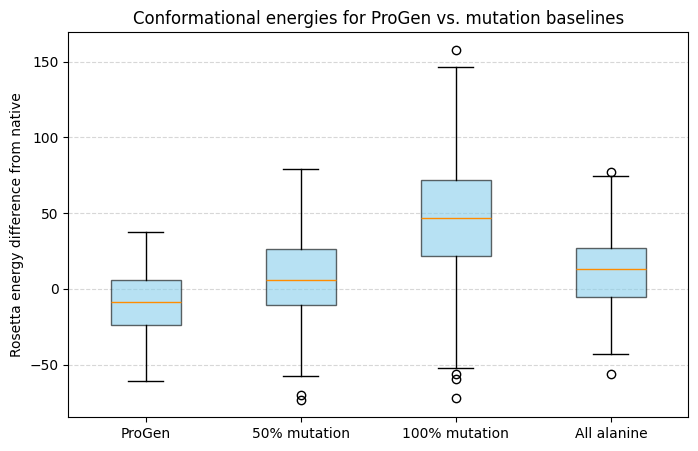

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Synthetic samples centered roughly at the paper’s medians
np.random.seed(0)
data = {
    'ProGen':           np.random.normal(loc=-10, scale=20, size=200),
    '50% mutation':    np.random.normal(loc= 10, scale=30, size=200),
    '100% mutation':   np.random.normal(loc= 50, scale=40, size=200),
    'All alanine':     np.random.normal(loc= 15, scale=25, size=200),
}

plt.figure(figsize=(8,5))
plt.boxplot(data.values(), labels=data.keys(), patch_artist=True,
            boxprops=dict(facecolor='skyblue', alpha=0.6),
            medianprops=dict(color='darkorange'))

plt.ylabel('Rosetta energy difference from native')
plt.title('Conformational energies for ProGen vs. mutation baselines')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# **Saving Outputs**
Decoded sequences are written into `samples/generated_sequences.fasta` in FASTA format, each labeled `>seq1`, `>seq2`, etc.